In [ ]:
from google.colab import drive
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

### Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Load Images file

In [ ]:
data = np.load('/content/drive/My Drive/Colab Notebooks/images.npy', allow_pickle=True)

In [ ]:
data.shape

(409, 2)

- our image data set has 409 images

#### Lets check a sample image

In [ ]:
print(data[350])

[array([[[77, 59, 60],
        [93, 75, 76],
        [89, 71, 72],
        ...,
        [18, 15, 14],
        [18, 15, 15],
        [18, 15, 15]],

       [[75, 56, 57],
        [89, 70, 71],
        [88, 68, 69],
        ...,
        [18, 15, 14],
        [18, 15, 15],
        [18, 15, 15]],

       [[67, 50, 50],
        [83, 66, 67],
        [85, 67, 68],
        ...,
        [18, 15, 15],
        [19, 16, 16],
        [19, 16, 16]],

       ...,

       [[21, 15, 15],
        [20, 15, 15],
        [21, 14, 13],
        ...,
        [83, 75, 76],
        [82, 74, 75],
        [81, 74, 74]],

       [[22, 17, 17],
        [21, 15, 16],
        [23, 16, 15],
        ...,
        [87, 81, 81],
        [85, 79, 80],
        [83, 77, 78]],

       [[24, 18, 19],
        [24, 18, 18],
        [24, 17, 16],
        ...,
        [85, 79, 80],
        [83, 78, 78],
        [82, 76, 76]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.32273262661955243, 'y': 0.244252

In [ ]:
print(data[350][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.32273262661955243, 'y': 0.2442528735632184}, {'x': 0.39811542991755006, 'y': 0.5258620689655172}], 'imageWidth': 849, 'imageHeight': 348}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.4110718492343934, 'y': 0.14655172413793102}, {'x': 0.4617196702002356, 'y': 0.28735632183908044}], 'imageWidth': 849, 'imageHeight': 348}]


In [ ]:
print(data[350][0])

[[[77 59 60]
  [93 75 76]
  [89 71 72]
  ...
  [18 15 14]
  [18 15 15]
  [18 15 15]]

 [[75 56 57]
  [89 70 71]
  [88 68 69]
  ...
  [18 15 14]
  [18 15 15]
  [18 15 15]]

 [[67 50 50]
  [83 66 67]
  [85 67 68]
  ...
  [18 15 15]
  [19 16 16]
  [19 16 16]]

 ...

 [[21 15 15]
  [20 15 15]
  [21 14 13]
  ...
  [83 75 76]
  [82 74 75]
  [81 74 74]]

 [[22 17 17]
  [21 15 16]
  [23 16 15]
  ...
  [87 81 81]
  [85 79 80]
  [83 77 78]]

 [[24 18 19]
  [24 18 18]
  [24 17 16]
  ...
  [85 79 80]
  [83 78 78]
  [82 76 76]]]


- we can notice there are 2 faces in this image

350th image


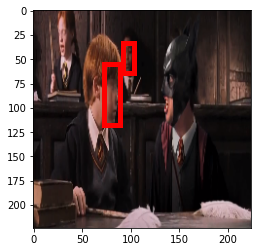

18th image


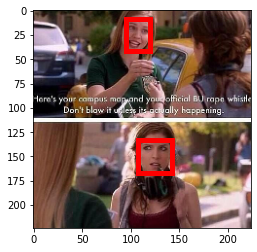

7th image


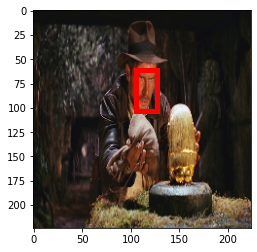

111th image


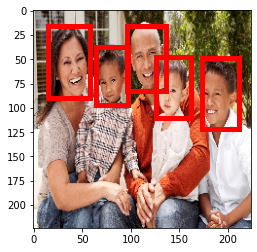

77th image


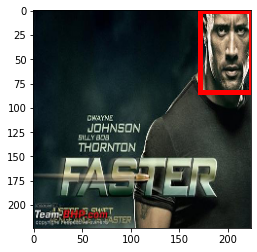

In [ ]:
for image in [350,18,7,111,77]:
  
  fig,ax = plt.subplots(1)
  print(str(image)+"th image")
  ax.imshow(cv2.resize(data[image][0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
  
  for faces in data[image][1]:
    x1 = faces["points"][0]['x']
    y1 = faces["points"][0]['y']
    x2 = faces["points"][1]['x']
    y2 = faces["points"][1]['y']
    rect = patches.Rectangle((x1*224, y1*224), (x2-x1)*224, (y2-y1)*224, linewidth=5, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

  plt.show()

### Set image Dimensions

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Creating Features and Labels
- features are images 
- masks are labels

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Train Test Split
- We will have 400 images on train 
- we will have 9 images in test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=9, random_state=1111)

print("Shape of the training set : ",X_train.shape)
print("Shape of the testing set : ",X_test.shape)

Shape of the training set :  (400, 224, 224, 3)
Shape of the testing set :  (9, 224, 224, 3)


### Print Sample images
#### All images from test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


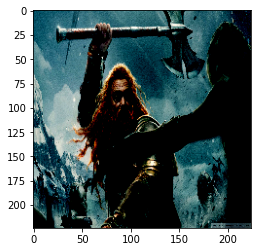

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


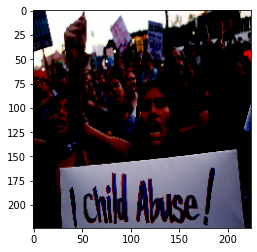

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


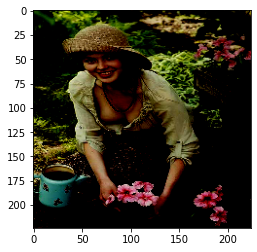

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


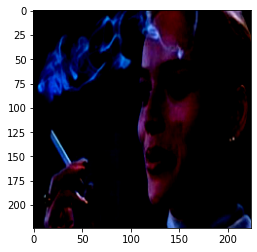

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


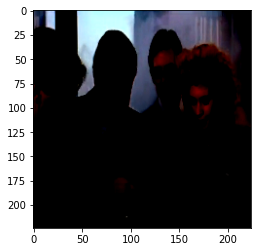

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


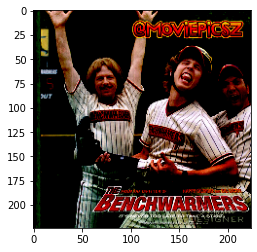

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


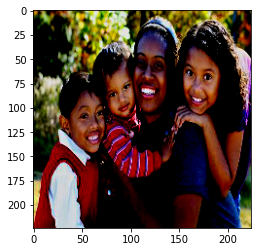

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


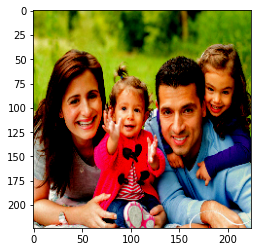

In [ ]:
for i in range(0,8):
  fig,ax = plt.subplots(1)
  ax.imshow(X_test[i])
  plt.show()

#### Some images from Train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


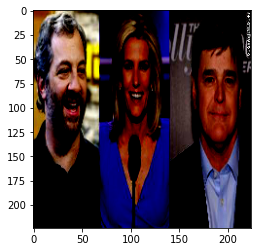

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


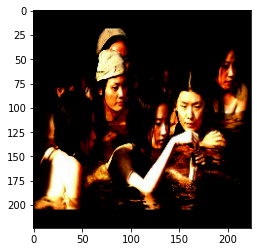

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


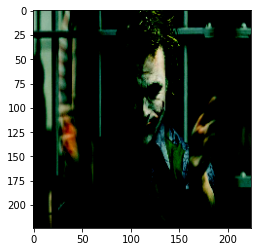

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


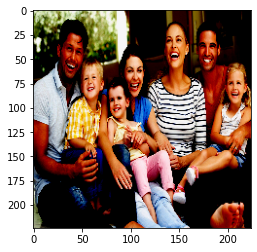

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


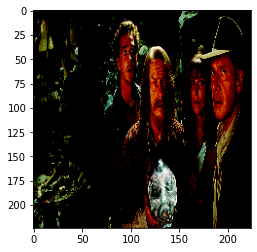

In [ ]:
for i in [4,16,74,270,391]:
  fig,ax = plt.subplots(1)
  ax.imshow(X_train[i])
  plt.show()

#### The masks of the images from the train set corresponding to the images above

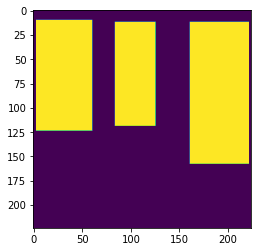

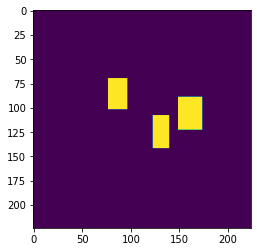

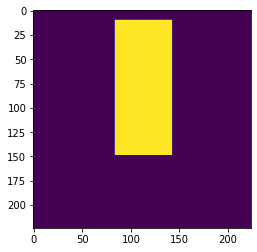

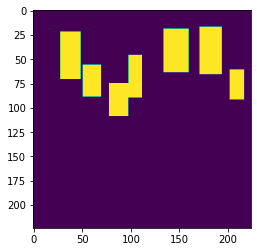

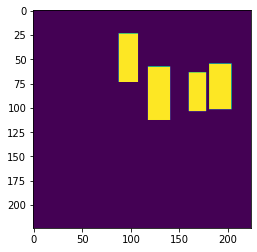

In [ ]:
for i in [4,16,74,270,391]:
  fig,ax = plt.subplots(1)
  ax.imshow(y_train[i])
  plt.show()

#### Here we are training our mobile net model so we have turned trainable as True

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    #upsampling block 4 output, last layer of block 3 is concatenated with it
    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)

    #the above result is upsampled and concatenated with the last layer of block 2
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)

    #the above result is upsampled and concatenated with the last layer of block 1
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)

    #the above result is upsampled and concatenated with the last layer of block 0
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)

    #upsampling without concatenation
    x = UpSampling2D()(x)
    print(x.shape)

    # 1x1 convulution is done with sigmoid activation function
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    #And finally reshaping is done corresponding the image height and width
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

### Creating The model

In [ ]:
model = create_model()

17227776/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


### Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Defining Dice Co-efficient

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

### DEfining Loss Function

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compiling the Model
- Optimizer = adam

In [ ]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### CallBacks

In [ ]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=10, mode="min",restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=15, min_lr=1e-6, verbose=1, mode="max", min_delta=0.01)

### Fit and Train the model

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=5, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/100
80/80 [==============================] - 446s 6s/step - loss: 0.8792 - dice_coefficient: 0.5862

Epoch 00001: loss improved from inf to 0.87917, saving model to model-0.88.h5
Epoch 2/100
80/80 [==============================] - 439s 5s/step - loss: 0.6341 - dice_coefficient: 0.6630

Epoch 00002: loss improved from 0.87917 to 0.63410, saving model to model-0.63.h5
Epoch 3/100
80/80 [==============================] - 440s 6s/step - loss: 0.5307 - dice_coefficient: 0.7045

Epoch 00003: loss improved from 0.63410 to 0.53073, saving model to model-0.53.h5
Epoch 4/100
80/80 [==============================] - 436s 5s/step - loss: 0.4601 - dice_coefficient: 0.7360

Epoch 00004: loss improved from 0.53073 to 0.46008, saving model to model-0.46.h5
Epoch 5/100
80/80 [==============================] - 441s 6s/step - loss: 0.4131 - dice_coefficient: 0.7587

Epoch 00005: loss improved from 0.46008 to 0.41310, saving model to model-0.41.h5
Epoch 6/100
80/80 [==============================

### Get the predicted mask for test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


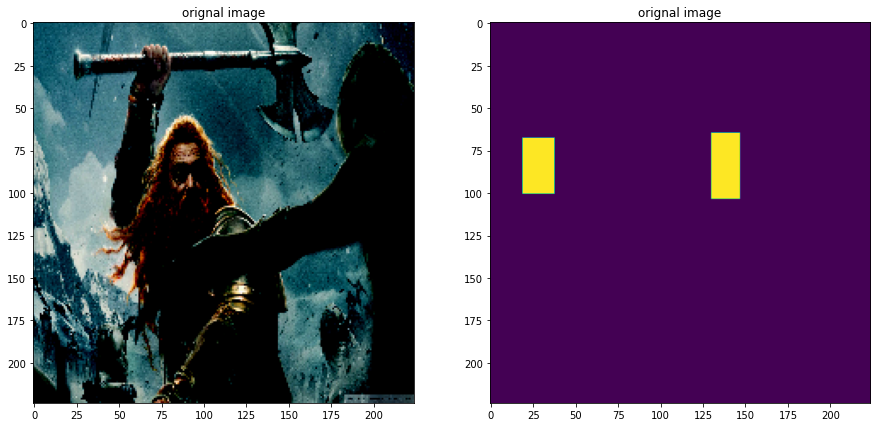

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


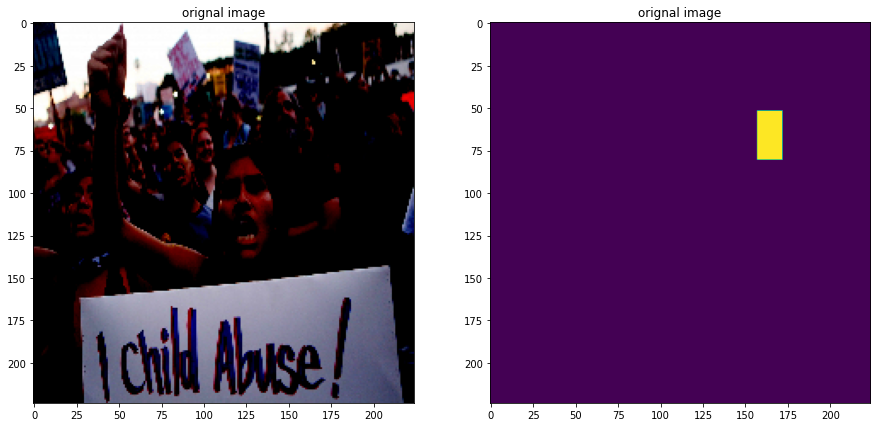

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


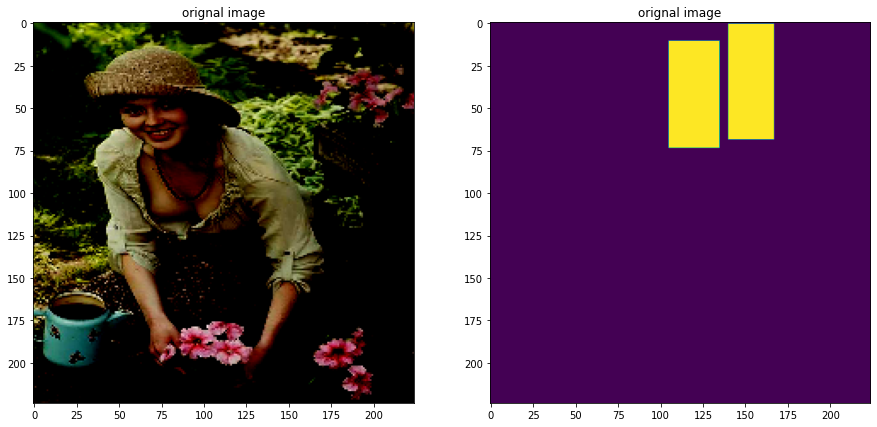

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


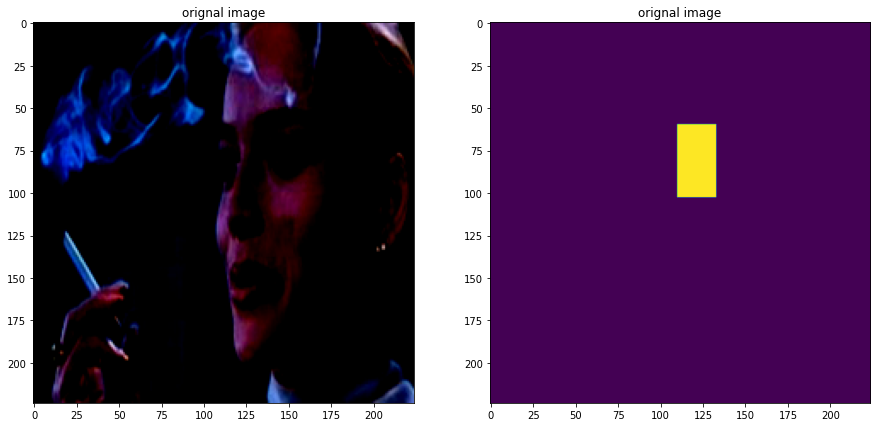

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


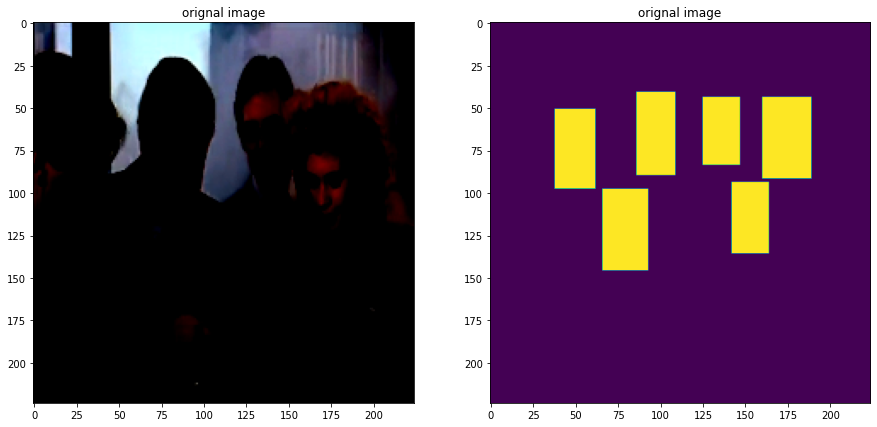

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


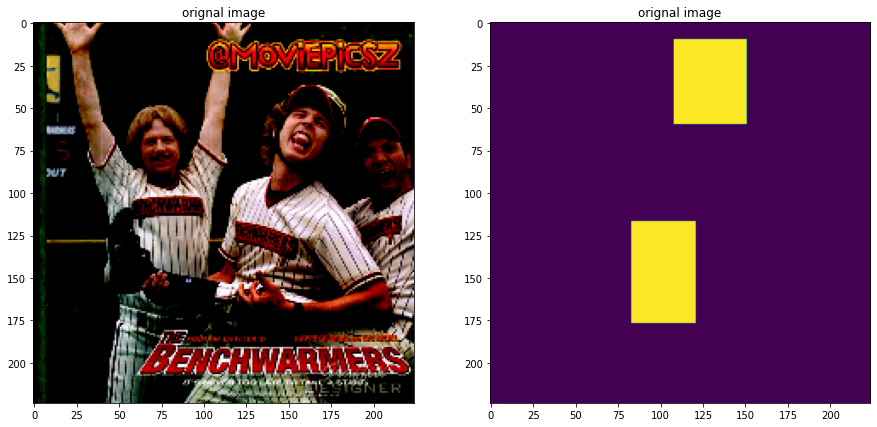

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


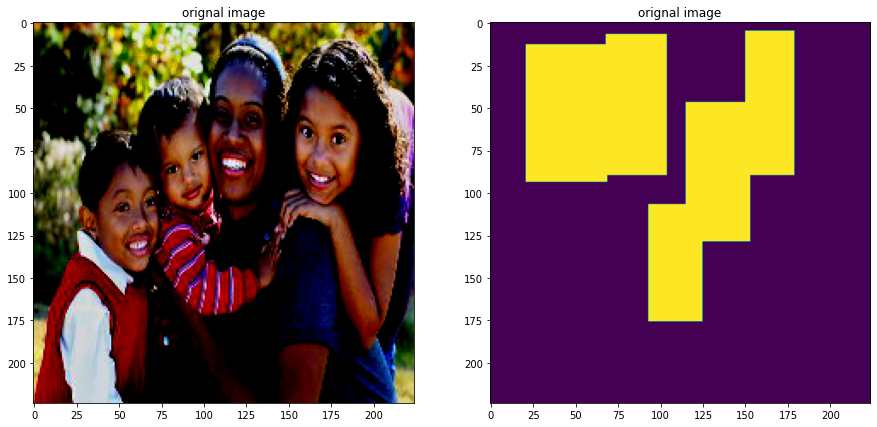

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


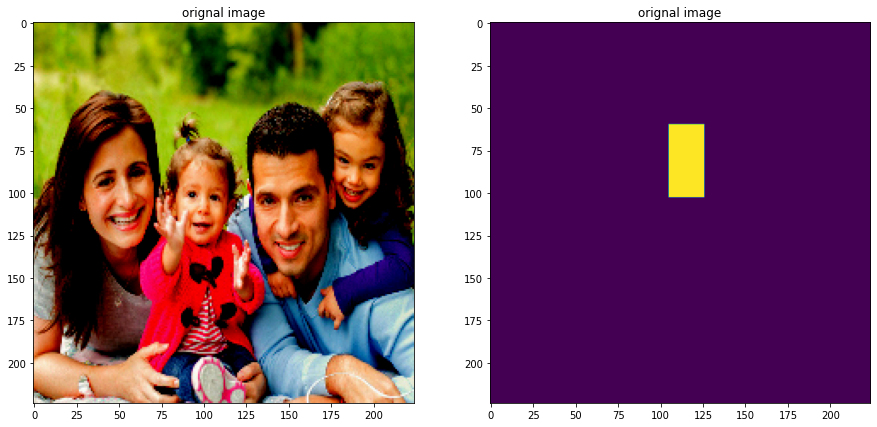

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


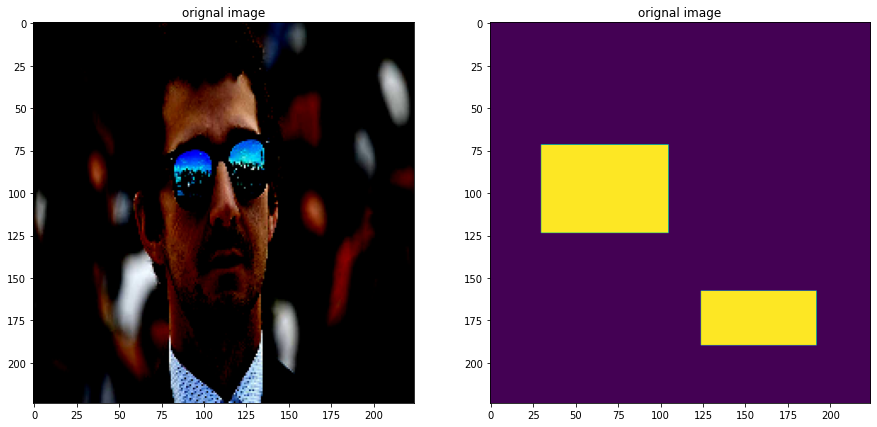

In [ ]:
for i in range(0,9):
  fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
  ax[0].imshow(X_test[i])
  ax[0].set_title("orignal image")

  ax[1].imshow(masks[i])
  ax[1].set_title("orignal image")
  plt.show()

### Impose the mask on the test image
- lets predict the mask on test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


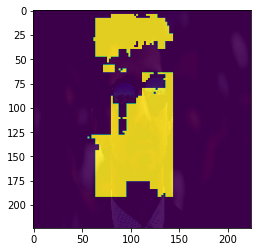

In [ ]:
pmk = cv2.resize(1.0 * (model.predict(x=np.array([X_test[8]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 
plt.imshow(X_test[8])
plt.imshow(pmk, alpha=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


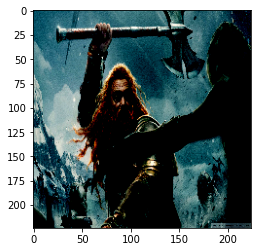

In [ ]:
plt.imshow(X_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


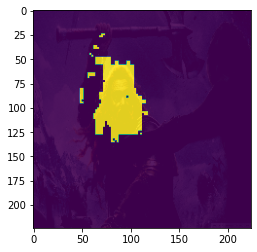

In [ ]:
pmk = cv2.resize(1.0 * (model.predict(x=np.array([X_test[0]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(X_test[0])
plt.imshow(pmk, alpha=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


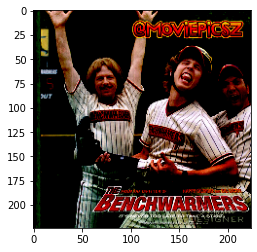

In [ ]:
plt.imshow(X_test[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


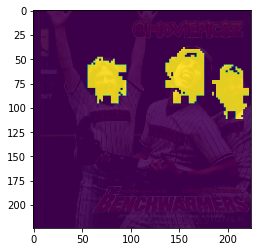

In [ ]:
pmk = cv2.resize(1.0 * (model.predict(x=np.array([X_test[5]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(X_test[5])
plt.imshow(pmk, alpha=0.9)

- we can see the result of our model predicting the images with masks above and the output are accurate at masking the faces.